Use Volume Traded Times Change In Price Over Interval As Signal

Large volume --> momentum.
Small volume --> reversal.

In [1]:
strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

## Load And Structure Data

In [2]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'

In [4]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for ADAUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XRPUSDT.
Downloaded data for DOTUSDT.
Downloaded data for MATICUSDT.


In [5]:
px_data

{'BTCUSDT':                                open            high             low  \
 open_time                                                             
 2020-01-01 00:00:00   7180.46000000   7238.03000000   7175.62000000   
 2020-01-01 04:00:00   7226.19000000   7231.70000000   7196.20000000   
 2020-01-01 08:00:00   7209.50000000   7231.17000000   7181.17000000   
 2020-01-01 12:00:00   7193.32000000   7244.43000000   7193.32000000   
 2020-01-01 16:00:00   7237.54000000   7245.54000000   7215.51000000   
 ...                             ...             ...             ...   
 2025-03-08 04:00:00  85923.80000000  86575.60000000  85923.00000000   
 2025-03-08 08:00:00  86161.93000000  86406.17000000  85776.85000000   
 2025-03-08 12:00:00  85966.70000000  86548.51000000  85868.09000000   
 2025-03-08 16:00:00  86453.18000000  86469.58000000  85746.38000000   
 2025-03-08 20:00:00  86299.16000000  86525.43000000  86211.15000000   
 
                               close       volume  

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def get_signals(price_volume_df):
    coin_signals = pd.DataFrame(0.0, columns = [], index=price_volume_df.index)

    coin_signals["price-1"] = price_volume_df["close"].shift()
    coin_signals["price-2"] = price_volume_df["close"].shift(2)
    coin_signals["log price-1"] = np.log(coin_signals["price-1"])
    coin_signals["log price-2"] = np.log(coin_signals["price-2"])
    coin_signals["price-1 - price-2"] = coin_signals["price-1"] - coin_signals["price-2"]
    coin_signals["price change rate"] = coin_signals["price-1"] / coin_signals["price-2"] - 1
    coin_signals["log price quotient"] = np.log(coin_signals["price-1"] / coin_signals["price-2"])

    coin_signals["volume-1"] = price_volume_df["volume"].shift()
    coin_signals.loc[coin_signals["volume-1"] == 0,"volume-1"] = 0.001
    coin_signals["volume-2"] = price_volume_df["volume"].shift(2)
    coin_signals.loc[coin_signals["volume-2"] == 0,"volume-2"] = 0.001
    coin_signals["log volume-1"] = np.log(coin_signals["volume-1"])
    coin_signals["log volume-2"] = np.log(coin_signals["volume-2"])
    coin_signals["volume-1 - volume-2"] = coin_signals["volume-1"] - coin_signals["volume-2"]
    coin_signals["volume change rate"] = coin_signals["volume-1"] / coin_signals["volume-2"] - 1
    coin_signals["log volume quotient"] = np.log(coin_signals["volume-1"] / coin_signals["volume-2"])

    price_columns = [
        "price-1", "price-2", "log price-1", "log price-2", "price-1 - price-2", "price change rate",
        "log price quotient"]

    volume_columns = [
        "volume-1", "volume-2", "log volume-1", "log volume-2", "volume-1 - volume-2", "volume change rate",
        "log volume quotient"
    ]

    for p_col in price_columns:
        for v_col in volume_columns:
            coin_signals[p_col + " x " + v_col] = coin_signals[p_col] * coin_signals[v_col]
    
    return coin_signals


def get_signals_for_all_coins(px_data):
    coin_to_signals = dict()

    for coin in px_data:
        price_volume_df = px_data[coin][["close", "volume"]].astype(float)
        coin_to_signals[coin] = get_signals(price_volume_df)
    
    return coin_to_signals


def get_models_for_all_coins(coin_to_signals, in_sample_end_datetime):
    coin_to_rfr_model = dict()

    for coin, signals in coin_to_signals.items():
        rfr_model = RandomForestRegressor(random_state=836)

        in_sample_signals = signals.iloc[2:].loc[:in_sample_end_datetime]
        in_sample_close_price = px_data[coin]['close'].iloc[2:].loc[:in_sample_end_datetime]

        rfr_model.fit(in_sample_signals, in_sample_close_price)
        coin_to_rfr_model[coin] = rfr_model
        print(f"Model fitted for {coin}.")
    
    return coin_to_rfr_model

#################################################################################################
#################################################################################################
#################################################################################################
#################################################################################################
#################################################################################################
#################################################################################################

In [13]:
for ticker in px_data:
    print(ticker)

BTCUSDT
ETHUSDT
ADAUSDT
BNBUSDT
XRPUSDT
DOTUSDT
MATICUSDT


In [14]:
btc_price_volume_df = px_data['BTCUSDT'][[
    "close", "volume", "quote_volume", "num_trades", "taker_base_volume", "taker_quote_volume"
]]
btc_price_volume_df = btc_price_volume_df.astype(float)
btc_price_volume_df

,close,volume,quote_volume,num_trades,taker_base_volume,taker_quote_volume
open_time,,,,,,
2020-01-01 00:00:00,7230.71,12.760445,92038.714925,136.0,6.774599,48856.545325
2020-01-01 04:00:00,7205.50,1.111320,8019.121424,64.0,0.518253,3740.423316
2020-01-01 08:00:00,7195.80,2.097358,15104.198332,61.0,1.105310,7957.894896
2020-01-01 12:00:00,7233.02,7.531506,54379.119990,111.0,4.235354,30569.135691
2020-01-01 16:00:00,7223.72,5.494401,39733.518352,80.0,2.658221,19232.354030
...,...,...,...,...,...,...
2025-03-07 20:00:00,86791.40,3.397940,293874.105268,959.0,1.706830,147562.319961
2025-03-08 00:00:00,86021.48,1.981330,170280.494665,352.0,0.234430,20226.781142
2025-03-08 04:00:00,86221.43,0.136750,11799.608238,112.0,0.089870,7760.997098


<Axes: xlabel='open_time'>

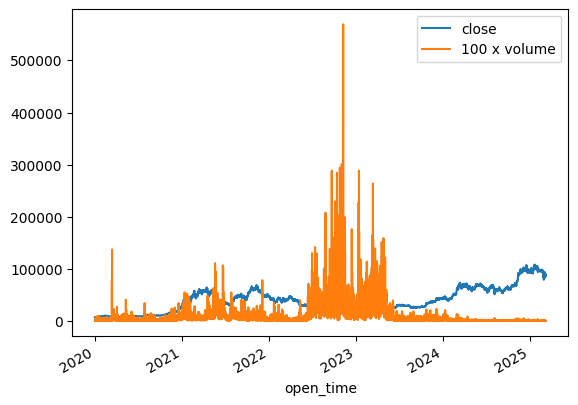

In [15]:
btc_price_volume_df["100 x volume"] = 100 * btc_price_volume_df["volume"]
btc_price_volume_df[["close", "100 x volume"]].plot()

In [16]:
btc_price_volume_df[["close", "volume"]].corr()

,close,volume
close,1.000000,-0.226463
volume,-0.226463,1.000000


In [17]:
import numpy as np

btc_price_volume_df[["volume", "quote_volume", "num_trades"]].corrwith(btc_price_volume_df["close"].shift(2))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


volume         -0.225643
quote_volume   -0.135278
num_trades     -0.133485
dtype: float64

In [18]:
btc_signals = pd.DataFrame(0.0, columns = [], index=btc_price_volume_df.index)

btc_signals["price-1"] = btc_price_volume_df["close"].shift()
btc_signals["price-2"] = btc_price_volume_df["close"].shift(2)
btc_signals["log price-1"] = np.log(btc_signals["price-1"])
btc_signals["log price-2"] = np.log(btc_signals["price-2"])
btc_signals["price-1 - price-2"] = btc_signals["price-1"] - btc_signals["price-2"]
btc_signals["price change rate"] = btc_signals["price-1"] / btc_signals["price-2"] - 1
btc_signals["log price quotient"] = np.log(btc_signals["price-1"] / btc_signals["price-2"])

btc_signals["volume-1"] = btc_price_volume_df["volume"].shift()
btc_signals["volume-2"] = btc_price_volume_df["volume"].shift(2)
btc_signals["log volume-1"] = np.log(btc_signals["volume-1"])
btc_signals["log volume-2"] = np.log(btc_signals["volume-2"])
btc_signals["volume-1 - volume-2"] = btc_signals["volume-1"] - btc_signals["volume-2"]
btc_signals["volume change rate"] = btc_signals["volume-1"] / btc_signals["volume-2"] - 1
btc_signals["log volume quotient"] = np.log(btc_signals["volume-1"] / btc_signals["volume-2"])

price_columns = [
    "price-1", "price-2", "log price-1", "log price-2", "price-1 - price-2", "price change rate",
    "log price quotient"]

volume_columns = [
    "volume-1", "volume-2", "log volume-1", "log volume-2", "volume-1 - volume-2", "volume change rate",
    "log volume quotient"
]

for p_col in price_columns:
    for v_col in volume_columns:
        btc_signals[p_col + " x " + v_col] = btc_signals[p_col] * btc_signals[v_col]

btc_signals

,price-1,price-2,log price-1,log price-2,price-1 - price-2,price change rate,log price quotient,volume-1,volume-2,log volume-1,...,price change rate x volume-1 - volume-2,price change rate x volume change rate,price change rate x log volume quotient,log price quotient x volume-1,log price quotient x volume-2,log price quotient x log volume-1,log price quotient x log volume-2,log price quotient x volume-1 - volume-2,log price quotient x volume change rate,log price quotient x log volume quotient
open_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7230.71,NaN,8.886093,NaN,NaN,NaN,NaN,12.760445,NaN,2.546350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7205.50,7230.71,8.882600,8.886093,-25.21,-0.003487,-0.003493,1.111320,12.760445,0.105548,...,0.040615,0.003183,0.008510,-0.003881,-0.044567,-0.000369,-0.008893,0.040686,0.003188,0.008525
2020-01-01 12:00:00,7195.80,7205.50,8.881253,8.882600,-9.70,-0.001346,-0.001347,2.097358,1.111320,0.740678,...,-0.001327,-0.001194,-0.000855,-0.002825,-0.001497,-0.000998,-0.000142,-0.001328,-0.001195,-0.000856
2020-01-01 16:00:00,7233.02,7195.80,8.886412,8.881253,37.22,0.005172,0.005159,7.531506,2.097358,2.019095,...,0.028108,0.013402,0.006613,0.038856,0.010821,0.010417,0.003821,0.028035,0.013367,0.006596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07 20:00:00,87845.69,88341.54,11.383337,11.388966,-495.85,-0.005613,-0.005629,1.963210,5.333620,0.674581,...,0.018918,0.003547,0.005610,-0.011050,-0.030021,-0.003797,-0.009423,0.018971,0.003557,0.005626
2025-03-08 00:00:00,86791.40,87845.69,11.371263,11.383337,-1054.29,-0.012002,-0.012074,3.397940,1.963210,1.223169,...,-0.017219,-0.008771,-0.006584,-0.041027,-0.023704,-0.014769,-0.008145,-0.017323,-0.008824,-0.006624
2025-03-08 04:00:00,86021.48,86791.40,11.362352,11.371263,-769.92,-0.008871,-0.008911,1.981330,3.397940,0.683768,...,0.012567,0.003698,0.004785,-0.017655,-0.030277,-0.006093,-0.010899,0.012623,0.003715,0.004806


In [19]:
btc_signals.corrwith(btc_price_volume_df["close"]).sort_values(ascending=False)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


price-1                       0.999695
price-2                       0.999417
log price-1                   0.934110
log price-2                   0.933924
price-1 x log volume-2        0.344851
                                ...   
log price-2 x log volume-2   -0.368375
log price-1 x log volume-1   -0.368690
log price-2 x log volume-1   -0.368801
log volume-2                 -0.452830
log volume-1                 -0.453110
Length: 63, dtype: float64

In [20]:
btc_signals.corr()["log volume-1"]["price-1 x log volume-2"]

0.4120680817306786

In [28]:
import statsmodels.api as sm

predictors_df = btc_signals[["log volume-1", "price-1 x log volume-2"]]
predictors_df = sm.add_constant(predictors_df)
predictors_df

,const,log volume-1,price-1 x log volume-2
open_time,,,
2020-01-01 00:00:00,1.0,NaN,NaN
2020-01-01 04:00:00,1.0,2.546350,NaN
2020-01-01 08:00:00,1.0,0.105548,18347.726020
2020-01-01 12:00:00,1.0,0.740678,759.505882
2020-01-01 16:00:00,1.0,2.019095,5357.342096
...,...,...,...
2025-03-06 20:00:00,1.0,1.029527,74591.144303
2025-03-07 00:00:00,1.0,1.100763,92648.031619
2025-03-07 04:00:00,1.0,2.358441,95610.572639


In [33]:
model = sm.OLS(btc_price_volume_df["close"].iloc[2:], predictors_df.iloc[2:])
results = model.fit()

results.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     6833.
Date:                Fri, 07 Mar 2025   Prob (F-statistic):               0.00
Time:                        08:29:40   Log-Likelihood:            -1.2585e+05
No. Observations:               11348   AIC:                         2.517e+05
Df Residuals:                   11345   BIC:                         2.517e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.866e+04    359.051    135.512      0.000     4.8e+04    4.94e+04
log volume-1           -1.024e+04     99.235   -103.231      0.000   -1.04e+04      -1e+04
price-1 x log volume-2     0.2164      0.002     92.482      0.000       0.212       0.221
==============================================================================
Omnibus:                     3016.139   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10955.482
Skew:                           1.303   Prob(JB):                         0.00
Kurtosis:                       7.048   Cond. No.                     3.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
results.predict([
    1.0,
    btc_signals.loc["2025-03-07 08:00:00", "log volume-1"],
    btc_signals.loc["2025-03-07 08:00:00", "price-1 x log volume-2"]
])

array([100933.73642974])

In [35]:
btc_price_volume_df.loc["2025-03-07 08:00:00", "close"]

88947.64

<Axes: xlabel='open_time'>

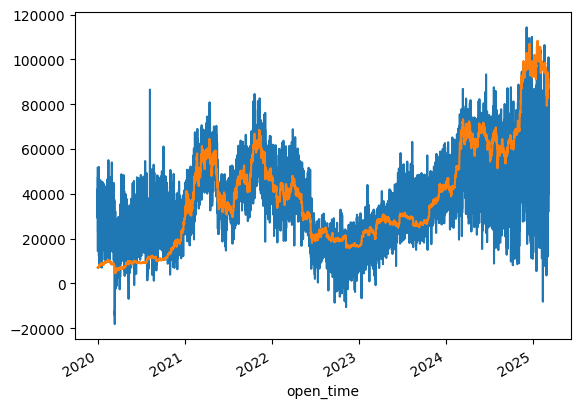

In [40]:
results.predict(predictors_df.iloc[2:]).plot()
btc_price_volume_df["close"].iloc[2:].plot()

In [42]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor(random_state=836)
rfr_model.fit(btc_signals.iloc[2:], btc_price_volume_df["close"].iloc[2:])

RandomForestRegressor(random_state=836)

In [45]:
rfr_model.predict(btc_signals.loc["2025-03-07 04:00:00":"2025-03-07 08:00:00"])

array([87989.5887, 88758.3261])

In [47]:
btc_price_volume_df.loc["2025-03-07 04:00:00":"2025-03-07 08:00:00", "close"]

open_time
2025-03-07 04:00:00    88363.46
2025-03-07 08:00:00    88947.64
Name: close, dtype: float64

In [48]:
data_len = len(btc_signals)

btc_signals_in_sample = btc_signals.iloc[2:(data_len//2)]
btc_signals_out_sample = btc_signals.iloc[(data_len//2):]

close_price_in_sample = btc_price_volume_df["close"].iloc[2:(data_len//2)]
close_price_out_sample = btc_price_volume_df["close"].iloc[(data_len//2):]

rfr_model_in_sample = RandomForestRegressor(random_state=836)
rfr_model_in_sample.fit(btc_signals_in_sample, close_price_in_sample)

RandomForestRegressor(random_state=836)

<Axes: xlabel='open_time'>

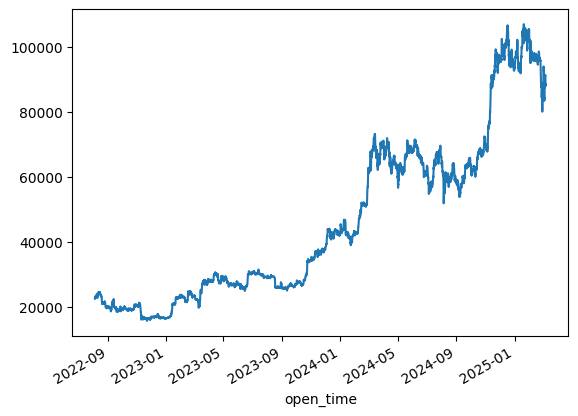

In [60]:
out_sample_predictions = rfr_model.predict(btc_signals_out_sample)
out_sample_predictions = pd.Series(out_sample_predictions, index=btc_signals_out_sample.index)

out_sample_predictions.plot()

<Axes: xlabel='open_time'>

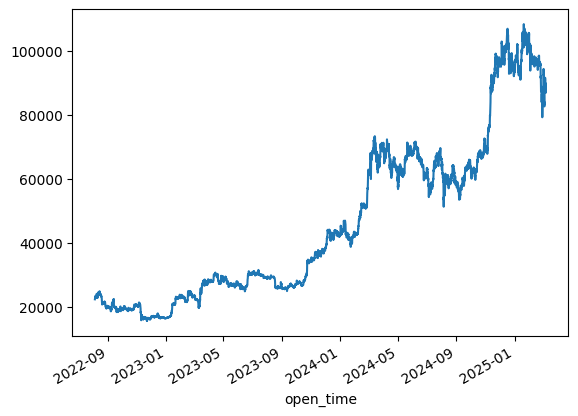

In [61]:
close_price_out_sample.plot()

<Axes: xlabel='open_time'>

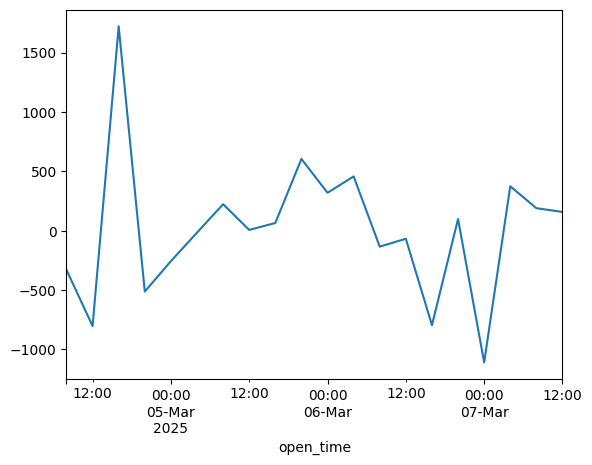

In [66]:
(close_price_out_sample - out_sample_predictions).iloc[-20:].plot()

In [65]:
rfr_model_in_sample.summary()

AttributeError: 'RandomForestRegressor' object has no attribute 'summary'